In [1]:
import pandas as pd
import numpy as np
import re, datetime
time = datetime.datetime.now
import matplotlib
import matplotlib.pyplot as plt#; import matplotlib.pylab as pylab
%matplotlib inline
matplotlib.style.use('bmh')
plt.rcParams['figure.figsize'] = 12, 6


In [2]:
# Load the stubhub daily data
st = time()
stubhub_dd_path = '../../Downloads/masterInventoryCsv_20170404.csv'
dd_df = pd.read_csv(stubhub_dd_path)
df = dd_df
df['primaryPerformerId'] = df.performerIdList.map(lambda x: [int(y) for y in re.split('[\[\]]', x) if y != ''][0])
print('Loaded Stubhub Dataframe and appended primary performer column. Total Time: {}'.format(time() - st))

Loaded Stubhub Dataframe and appended primary performer column. Total Time: 0:00:01.819821


In [3]:
# Check columns, check head rows
print dd_df.columns
df.head()

Index([u'_id', u'city', u'currPriceMean', u'currPriceStd', u'currQuint0',
       u'currQuint1', u'currQuint2', u'currQuint3', u'currQuint4',
       u'currQuint5', u'date', u'dateOnsale', u'daysToEvent', u'eventDate',
       u'eventId', u'eventName', u'eventUrl', u'latitude', u'listPriceMean',
       u'listPriceStd', u'listQuint0', u'listQuint1', u'listQuint2',
       u'listQuint3', u'listQuint4', u'listQuint5', u'longitude',
       u'performerIdList', u'performerNameList', u'pullDate',
       u'recordedListings', u'recordedTickets', u'score', u'totalListings',
       u'totalTickets', u'venueId', u'venueName', u'primaryPerformerId'],
      dtype='object')


,_id,city,currPriceMean,currPriceStd,currQuint0,currQuint1,currQuint2,currQuint3,currQuint4,currQuint5,...,performerNameList,pullDate,recordedListings,recordedTickets,score,totalListings,totalTickets,venueId,venueName,primaryPerformerId
0,58ab9a3bf97ae263cbf6e342,San Francisco,171.767875,32.454198,122.50,140.50,171.91,182.50,194.50,242.50,...,[u'Into the Woods San Francisco'],2017-02-21 01:39:07.837650,12.0,80.0,0.3269,12.0,80.0,407.0,Golden Gate Theatre,1512595
1,58ab9a42f97ae263cbf6e343,San Francisco,229.598333,139.856425,48.44,129.70,156.10,194.50,307.65,810.31,...,[u'Into the Woods San Francisco'],2017-02-21 01:39:14.146928,19.0,84.0,0.3269,19.0,84.0,407.0,Golden Gate Theatre,1512595
2,58ab9a48f97ae263cbf6e344,San Francisco,233.061760,125.043125,97.30,140.50,176.50,242.50,260.61,810.31,...,[u'Into the Woods San Francisco'],2017-02-21 01:39:20.386801,31.0,125.0,0.3269,31.0,125.0,407.0,Golden Gate Theatre,1512595
3,58ab9a4ef97ae263cbf6e345,San Francisco,162.012360,27.020107,106.05,132.58,148.25,178.90,194.50,194.50,...,[u'Into the Woods San Francisco'],2017-02-21 01:39:26.586477,18.0,89.0,0.3269,18.0,89.0,407.0,Golden Gate Theatre,1512595
4,58ab9a54f97ae263cbf6e346,San Francisco,158.184375,34.920125,65.25,129.70,146.50,181.78,194.50,194.50,...,[u'Into the Woods San Francisco'],2017-02-21 01:39:32.786721,13.0,64.0,0.3269,13.0,64.0,407.0,Golden Gate Theatre,1512595


In [150]:
# Unique events, venues, dates, pull dates, performers
unique_events = df.eventId.unique()
unique_venues = df.venueId.unique()
unique_dates = df.eventDate.map(lambda x: str(x)[:10]).unique()
unique_pull_dates = df.pullDate.map(lambda x: str(x)[:10]).unique()
performers = []
# Append to performers
df.performerIdList.map(lambda x: [performers.append(p_id) for p_id in 
                                 [int(y) for y in re.split('[\[\]]', x) if y != '']])
unique_performers = pd.Series(performers).unique()
print('Unique events: {}\nUnique venues: {}\nUnique event dates: {}\nUnique pull dates: {}\nUnique performers: {}'
      .format(len(unique_events), len(unique_venues), len(unique_dates), len(unique_pull_dates), len(unique_performers)))

Unique events: 15604
Unique venues: 483
Unique event dates: 487
Unique pull dates: 42
Unique performers: 1909


In [164]:
performer_importance_df = performer_df.sort_values('ticket_count_avg')[::-1].dropna()

In [160]:
# Create dictionary mapping performerId --> average ticket count in last 30 days
# Note: This should be useful in identifying a performers popularity
st = time()
performerTicketCount_dict = {}
temp_performerIdList_series = df.performerIdList.map(lambda x: [int(y) for y in re.split('[\[\]]', x) if y != ''])
for performerId in unique_performers:
    # Note: Think about winsorizing ticket counts when calculating the mean
    temp_performer_df = df[temp_performerIdList_series.map(lambda x: performerId in x)] # filter for events of this performer   
    temp_ticketCount_mean = temp_performer_df[temp_performer_df.daysToEvent < 30].totalTickets.mean()
    performerTicketCount_dict[str(performerId)] = temp_ticketCount_mean
performer_df = pd.DataFrame.from_dict(performerTicketCount_dict, orient = 'index')
performer_df.columns = ['ticket_count_avg']
performer_df['name'] = performer_df.index.map(lambda x: df[df.primaryPerformerId == int(x)].performerNameList)
print('Completed creating performer ticket-count mapping. Total Time: {}'.format(time() - st))

Completed creating performer ticket-count mapping. Total Time: 0:01:38.466642


In [6]:
# Create dictioanry mapping eventId --> mean currQuint0 price across all dates
# Note: using currQuint0 because those are the ticket offers that get most frequently executed
meanCurrQuint0_dict = {}
st = time()
for eventId in unique_events:
    temp_df = df[df.eventId == eventId]
    meanpriceXtickets_series = temp_df.currQuint0 * temp_df.totalTickets # important to scale by daily ticket count
    meanPrice = meanpriceXtickets_series.mean() / float(temp_df.totalTickets.mean())
    meanCurrQuint0_dict[str(eventId)] = meanPrice
print('Completed creating mean currQuint0-price by eventId mapping. Total Time: {}'.format(time() - st))

Completed creating mean currQuint0-price by eventId mapping. Total Time: 0:00:14.847287


In [7]:
# Create dictioanry mapping eventId --> mean (currQuint0+currQuint1)/2 price across all dates
# Note: using currQuint0+currQuint1 because those are the ticket offers that get most frequently executed
meanCurrQuint01_dict = {}
st = time()
for eventId in unique_events:
    temp_df = df[df.eventId == eventId]
    meanpriceXtickets_series = ((temp_df.currQuint0 + temp_df.currQuint1)/2.0) * temp_df.totalTickets # important to scale by daily ticket count
    meanPrice = meanpriceXtickets_series.mean() / float(temp_df.totalTickets.mean())
    meanCurrQuint01_dict[str(eventId)] = meanPrice
print('Completed creating mean currQuint01-price by eventId mapping. Total Time: {}'.format(time() - st))

Completed creating mean currQuint01-price by eventId mapping. Total Time: 0:00:19.119713


In [8]:
# Create column 'currQuint0Score' representing currQuint0 / average currQuint0 price (for given event)
## (This score should have an approximately normal distribution)
st = time()
df['currQuint0Score'] = df.index.map(lambda x: df.ix[x].currQuint0 / meanCurrQuint0_dict[str(df.ix[x].eventId)])
print('Completed creating \'currQuint0Score\' column. Total Time: {}'.format(time() - st))

Completed creating 'currQuint0Score' column. Total Time: 0:00:46.669385


In [9]:
# Create column 'currPriceScore' representing currQuint0 / average currQuint0 price (for given event)
## (This score should have an approximately normal distribution)
st = time()
df['currQuint01Score'] = df.index.map(lambda x: ((df.ix[x].currQuint0 + df.ix[x].currQuint1)/2.0) / meanCurrQuint01_dict[str(df.ix[x].eventId)])
print('Completed creating \'currQuint01Score\' column. Total Time: {}'.format(time() - st))

Completed creating 'currQuint01Score' column. Total Time: 0:01:15.871916


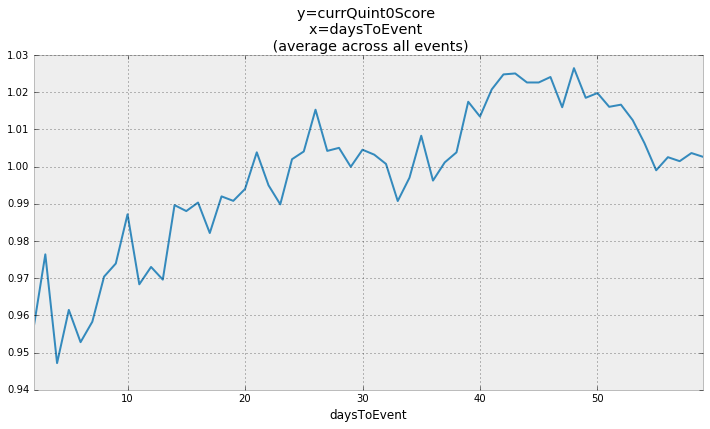

In [147]:
daysToEvent_filt = (df.daysToEvent < 60) * ((df.daysToEvent > 1))
ticketCount_filt = df.totalTickets > 100
winsorize_filt_upper = df.currQuint0Score < (df.currQuint0Score.mean() + 1.5*df.currQuint0Score.std())
winsorize_filt_lower = df.currQuint0Score > (df.currQuint0Score.mean() - 1.5*df.currQuint0Score.std())
performer_filt = df.primaryPerformerId.map(lambda x: performerTicketCount_dict[str(x)] > 250)
score_filt = (df.score < .5) * (df.score > .345) # This should remove sport events and irrelevant artists
state_filt = df.date.isin(['CA', 'NY'])
city_filt = df.city.isin(['San Francisco', 'Los Angeles'])
temp_plot_title = 'y=currQuint0Score \nx=daysToEvent \n (average across all events)'
final_filter = daysToEvent_filt * winsorize_filt_upper * winsorize_filt_lower * performer_filt * state_filt
df[final_filter].groupby(df.daysToEvent).mean().currQuint0Score.plot(title = temp_plot_title)

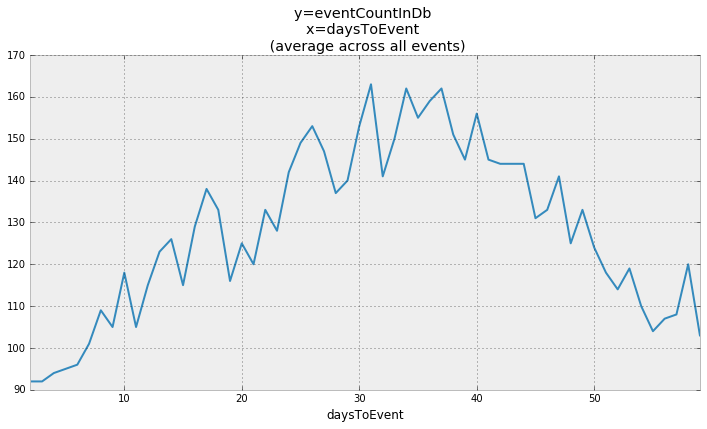

In [148]:
df[final_filter].groupby(df.daysToEvent).count().currQuint01Score.plot(title = 
                                                        temp_plot_title.replace('currQuint0Score', 'eventCountInDb'))

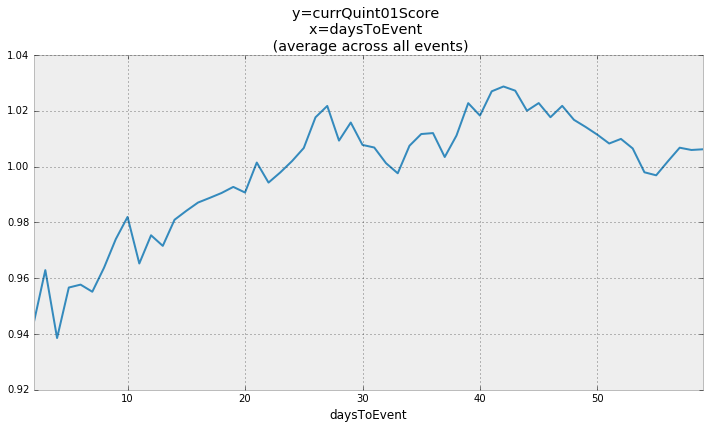

In [149]:
df[final_filter].groupby(df.daysToEvent).mean().currQuint01Score.plot(title = 
                                                        temp_plot_title.replace('currQuint0Score', 'currQuint01Score'))

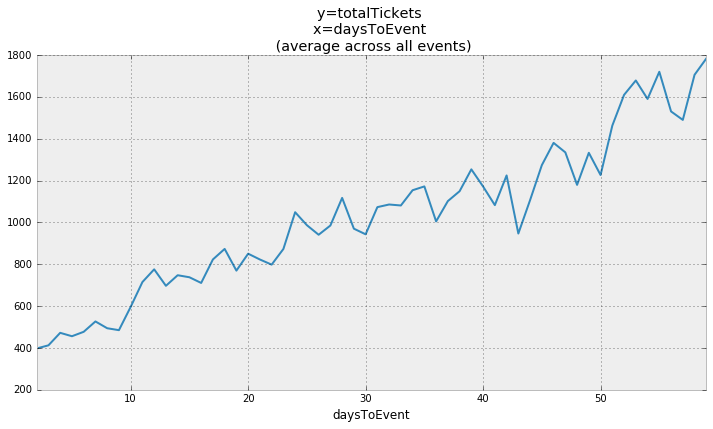

In [12]:
df[final_filter].groupby(df.daysToEvent).mean().totalTickets.plot(title = 
                                                        temp_plot_title.replace('currQuint0Score', 'totalTickets'))

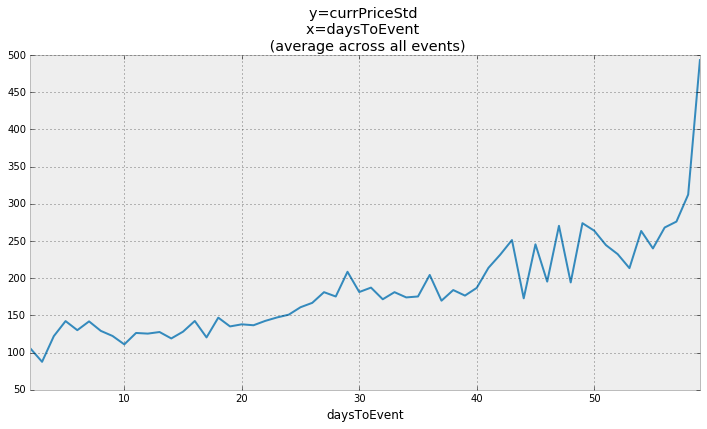

In [13]:
df[final_filter].groupby(df.daysToEvent).mean().currPriceStd.plot(title = 
                                                        temp_plot_title.replace('currQuint0Score', 'currPriceStd'))

In [14]:
df[(df.score < 1) * (df.score > .345)].city.unique()

array(['Chicago', 'Rosemont', 'Oakland', 'San Francisco', 'Berkeley',
       'Los Angeles', 'Hollywood', 'Long Beach', 'Inglewood', 'Pasadena',
       'New York', 'Manhattan', 'Brooklyn', 'Santa Barbara', 'Seattle',
       'Vienna', 'Washington', 'Fairfax', 'National Harbor', 'Landover',
       'Englewood', 'Denver', 'Morrison'], dtype=object)

In [15]:
df.columns

Index([u'_id', u'city', u'currPriceMean', u'currPriceStd', u'currQuint0',
       u'currQuint1', u'currQuint2', u'currQuint3', u'currQuint4',
       u'currQuint5', u'date', u'dateOnsale', u'daysToEvent', u'eventDate',
       u'eventId', u'eventName', u'eventUrl', u'latitude', u'listPriceMean',
       u'listPriceStd', u'listQuint0', u'listQuint1', u'listQuint2',
       u'listQuint3', u'listQuint4', u'listQuint5', u'longitude',
       u'performerIdList', u'performerNameList', u'pullDate',
       u'recordedListings', u'recordedTickets', u'score', u'totalListings',
       u'totalTickets', u'venueId', u'venueName', u'primaryPerformerId',
       u'currQuint0Score', u'currQuint01Score'],
      dtype='object')

In [136]:
#Show specific eventID plots
search_name = 'jack johnson'
index = 1
temp_eventId = list(df[df.performerNameList.map(lambda x: search_name in str(x).lower())].eventId)[index]
print 'EventId: {}'.format(temp_eventId)
print ['Performers: {}. Venue Name: {}'.format(list(df[df.eventId == temp_eventId]['performerNameList'])[0], 
                                               list(df[df.eventId == temp_eventId]['venueName'])[0])]

EventId: 9825983.0
["Performers: [u'Jack Johnson']. Venue Name: Greek Theatre Berkeley Parking Lots"]


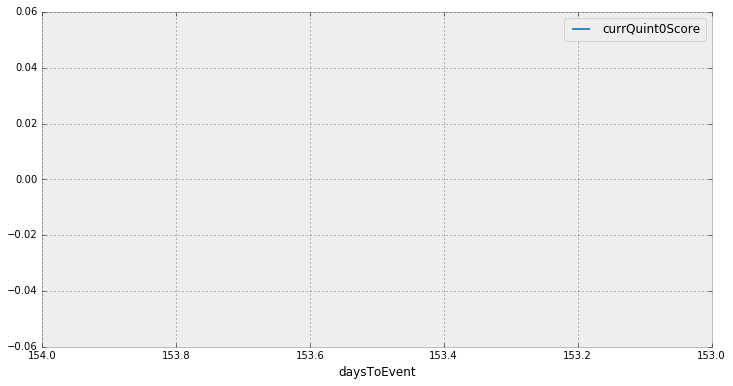

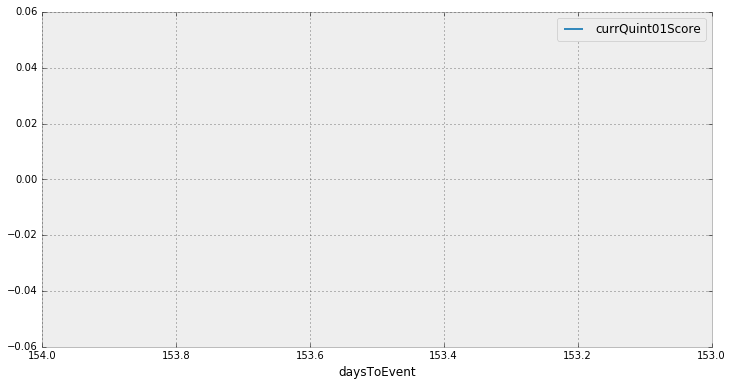

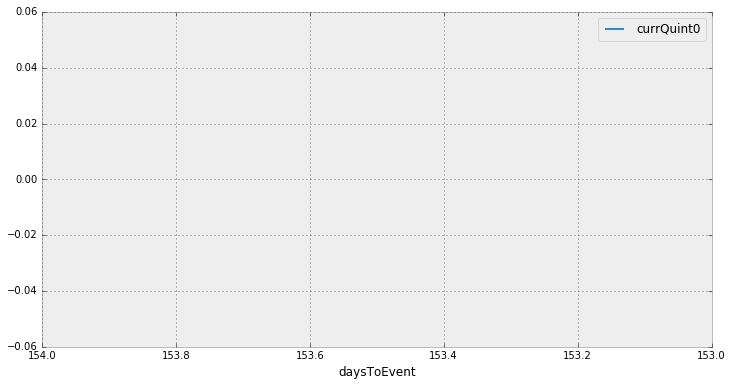

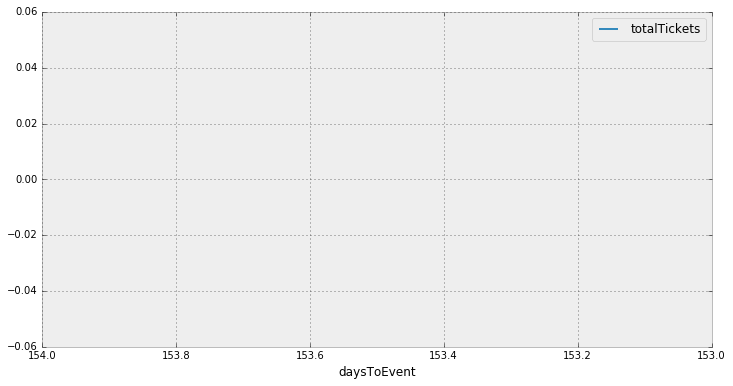

In [137]:
df[df.eventId == temp_eventId].plot(x = 'daysToEvent', y = 'currQuint0Score')
df[df.eventId == temp_eventId].plot(x = 'daysToEvent', y = 'currQuint01Score')
df[df.eventId == temp_eventId].plot(x = 'daysToEvent', y = 'currQuint0')
df[df.eventId == temp_eventId].plot(x = 'daysToEvent', y = 'totalTickets')
